### Script to get average beam energy per run for GMn/nTPE confidurations using `HALLA_p` (from E tree) variable [CREATED 02/08/23]
Until now we have been using a beam enrgy number that was put in the GMn run list by the shift crew but that is not precise enough for physics analysis. Hence, I am trying to determine the best was to get the beam energy for all the runs. Observations we make using this script should give us some insight on the above mentioned matter. Configuration file `conf_get_avgHALLA_p_prun.json` is needed to execute this script.
#### Issues
1. `HALLA_p` variable that carries the beam energy we get from some EPICS variable can be found in the EPICS tree (E) as well as in the T tree. There is a caveat though. EPICS events are only once in 8 seconds or so whereas our event rate is ~ 2.5kHz. As a consequence, we don't have a beam energy value for every physics event. So, it is not a one-to-one mapping between E tree and T tree.
2. Our replay takes care of the above mentioned issue to some extent by recording the same EPICS value for every physics event between two EPICS events. This would mean that we should just be able to use `HALLA_p` variable from T tree two get beam energy every event but there is still another issue. Since, we have recorded a huge amount of data every run, our raw data file (.evio) as well as the replay file have several segments per run. Whenever there is a change of segment during replay, podd fills the `HALLA_p` variable with some absurdly large negative number until it finds the first EPICS event. As a result, at the beginning of every segment a bunch of events don't really have a HALLA_p value. Since, we don't really store info about the segment number in the tree, surpassing this issue becomes complicated. 

#### Possible Approaches 
1. Defining event range: Andrew's idea, "A better approach is to chain together all the root files from a given run and then define event ranges and beam energy values between EPICS events from the EPICS tree (“E”). For some of the pass 0 and pass 1 replays this method won’t work, since the global event counting is not working properly in earlier versions of SBS-offline/Podd. But that is the scheme you probably want to implement for the final analysis. That method would guarantee that every event after the first EPICS event in any given CODA run will have a valid HALLA_p value (assuming the beam was on when that event was recorded, but that is a separate issue). For the events from the beginning of the run to the first EPICS event you could use the HALLA_p from the first EPICs event."
2. The **easiest approach** is to get an average `HALLA_p` value per run by looping through E tree and use that number for analysis. Here is Andrew's opinion on this, "In the mean time, a safer but arguably less precise approach would be to take the average of all HALLA_p values in the EPICs tree and use that as a single beam energy value for analysis of a given run. Because the EPICs events are “slow” you aren’t really getting an “instantaneous” beam energy that is in sync with the physics events anyway. So just using an average is probably just as good in terms of accuracy." <span style="color:red">Both Mark & Bogdan think this approach should be good enough for our analysis. We will take this approach in this script.</span>

#### Implementation Ideas
1. For the 2nd approach I want to do the following:
    - Create a CSV file with run number and average HALLA_p values per run for every configuration per target type.
    - Then while looping through the T tree for physics analysis I will grab the run number for every event and read the `HALLA_p` value from the CSV file.
2. For the 1st approach I plan to do the following:
    - Sort by segment numbers before chaining together ROOT files from a given run.
    - For a unique run use the `HALLA_p` branch from tree and then replace the large negative values of the first however many events with the `HALLA_p` value of the last event of previous segment. NOTE: In case of `seg0-0` use a table that contain the first `HALLA_p` value per runnumber.

#### A few Observations through this Study
1. Average beam energy vs. run number plot (the error bars represented std) revealed that there are a handful of runs that have much higher spread than the rest of them. 
2. Further investigation revealed that one or two EPICS events of those runs have `HALLA_p` value recorded as 0! Reason behind this is unkown but it seemed pretty clear that those events were responsible for higher spread and shifted the mean as well. After filtering out those values from analysis, average beam energy and its spread looked quite reasonable across all the runs.
3. We got one EPICS event roughly every 20K events, which makes sense given our trigger rate. 
4. Several runs have multiple entries for single global event number! 
    - Not sure about the reason yet! Need to further filter the dataset requiring unique event number per run. <span style="color:red">Done</span>     

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/home/pdbforce/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Reading config file
conf_file = open('conf_get_avgHALLA_p_prun.json')
conf = json.load(conf_file)
print("Config file for SBS-{}, {} data has been loaded..".format(conf['SBS_config'], conf['target']))

Config file for SBS-4, LH2 data has been loaded..


In [3]:
# Reading CSV file generated from get_avgHALLA_p_prun.cpp script. It should contain HALLA_p values and global event numbers per run
ebeamdf = pd.DataFrame(pd.read_csv("epout/get_HALLA_p_prun_SBS{}_{}.csv".format(conf['SBS_config'], conf['target'])))
ebeamdf['HALLA_p_gev'] = ebeamdf['HALLA_p'] / 1000.0  # let's add a column for ebeam value in GeV
ebeamdf.head()

,runnum,evnum,HALLA_p,HALLA_p_gev
0,11436,63373,3728.21,3.72821
1,11436,116184,3728.13,3.72813
2,11436,170027,3728.18,3.72818
3,11436,224502,3728.22,3.72822
4,11436,278493,3728.17,3.72817


In [4]:
# Calculating mean and std of beam energy per run
avgebeamdf = ebeamdf.groupby('runnum').agg({'HALLA_p_gev':['mean','std']}).reset_index()
avgebeamdf.head()

runnum HALLA_p_gev          
                mean       std
0  11436    3.728110  0.000158
1  11500    3.728207  0.000137
2  11547    3.727972  0.000171
3  11548    3.727826  0.000073
4  11573    3.728115  0.000126

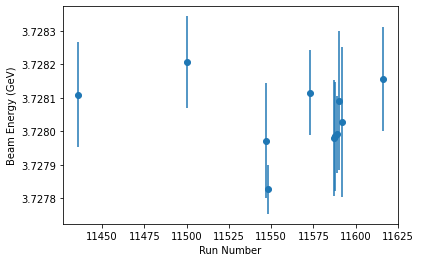

In [5]:
# Plotting average HALLA_p as a function of run numbers (std values are shown as yerrors)
cut_sigma = avgebeamdf['HALLA_p_gev']['std'] < 1 #0.0006 # Defining a cut definition to choose range of std
plt.errorbar(avgebeamdf['runnum'][cut_sigma], avgebeamdf['HALLA_p_gev']['mean'][cut_sigma], yerr=avgebeamdf['HALLA_p_gev']['std'][cut_sigma], fmt='o')
#plt.xticks(avgebeamdf['runnum'], rotation=90)
#plt.xlim(12670,12700)
plt.xlabel('Run Number')
plt.ylabel('Beam Energy (GeV)')
plt.show()

### Filtering out ebeamdf for the following two things
1. HALLA_p > 0
2. Unique EPICS event for a unique global event

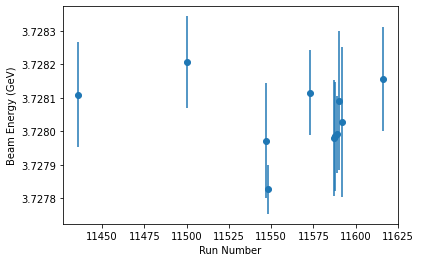

In [6]:
# 1. HALLA_p > 0
ebeamdf_nz = ebeamdf[ebeamdf['HALLA_p'] != 0] # applying the filter
# Calculating mean and std of beam energy per run again with filtered data
avgebeamdf_nz = ebeamdf_nz.groupby('runnum').agg({'HALLA_p_gev':['mean','std']}).reset_index()
# Plotting average HALLA_p as a function of run numbers (std values are shown as yerrors)
cut_sigma_nz = avgebeamdf_nz['HALLA_p_gev']['std'] < 1 #0.0006 # Defining a cut definition to choose range of std
plt.errorbar(avgebeamdf_nz['runnum'][cut_sigma], avgebeamdf_nz['HALLA_p_gev']['mean'][cut_sigma], yerr=avgebeamdf_nz['HALLA_p_gev']['std'][cut_sigma], fmt='o')
#plt.xticks(avgebeamdf['runnum'], rotation=90)
#plt.xlim(12670,12700)
plt.xlabel('Run Number')
plt.ylabel('Beam Energy (GeV)')
plt.show()

In [7]:
# 2. Unique EPICS event for a unique global event
ebeamdf_nz_nd = ebeamdf_nz.drop_duplicates(subset=['runnum', 'evnum'], keep='first')
ebeamdf_nz_nd.head()

,runnum,evnum,HALLA_p,HALLA_p_gev
0,11436,63373,3728.21,3.72821
1,11436,116184,3728.13,3.72813
2,11436,170027,3728.18,3.72818
3,11436,224502,3728.22,3.72822
4,11436,278493,3728.17,3.72817


In [8]:
# Calculating total no of EPICS events per run before and after filtering duplicate entries
# before
nevents_epics_bf = ebeamdf_nz['runnum'].value_counts().reset_index()
nevents_epics_bf_df = pd.DataFrame(nevents_epics_bf)
nevents_epics_bf_df.columns = ['runnum', 'nevents']
#nevents_epics.to_frame() # this is not working! No clue why!
# after
nevents_epics_af = ebeamdf_nz_nd['runnum'].value_counts().reset_index()
nevents_epics_af_df = pd.DataFrame(nevents_epics_af)
nevents_epics_af_df.columns = ['runnum', 'nevents']
# calculate difference for a particular run
#nevents_epics_bf_df[nevents_epics_bf_df['runnum'] == 12902] - nevents_epics_af_df[nevents_epics_af_df['runnum'] == 12902]

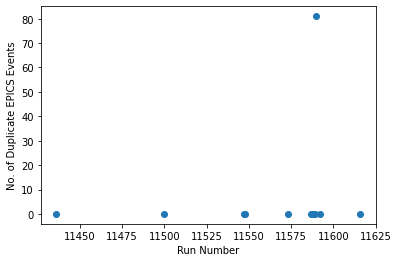

In [9]:
# Take difference in total number of EPICS events before and after and then plot the values vs run numbers
ndup_prun = pd.merge(nevents_epics_bf, nevents_epics_af, on='runnum', suffixes=('', '_ndup'))
ndup_prun['ndup'] = ndup_prun['nevents'] - ndup_prun['nevents_ndup']
plt.scatter(x=ndup_prun['runnum'], y=ndup_prun['ndup'])
plt.xlabel('Run Number')
plt.ylabel('No. of Duplicate EPICS Events')
plt.show()

In [10]:
# # Calculating final mean and std of beam energy per run with completely filtered data
avgebeamdf_nz_nd = ebeamdf_nz_nd.groupby('runnum').agg({'HALLA_p_gev':['mean','std']}).reset_index()
avgebeamdf_nz_nd.head()

runnum HALLA_p_gev          
                mean       std
0  11436    3.728110  0.000158
1  11500    3.728207  0.000137
2  11547    3.727972  0.000171
3  11548    3.727826  0.000073
4  11573    3.728115  0.000126

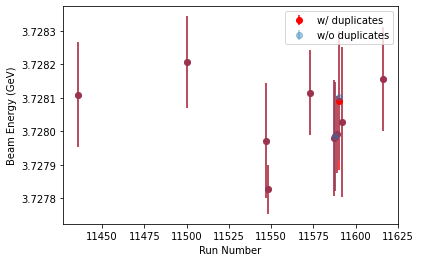

In [11]:
# Plotting HALLA_p as a function of run numbers w/ and w/o cuts on duplicate EPICS events
cut_sigma = avgebeamdf_nz['HALLA_p_gev']['std'] < 1
cut_sigma_nd = avgebeamdf_nz_nd['HALLA_p_gev']['std'] < 1
plt.errorbar(avgebeamdf_nz['runnum'][cut_sigma], avgebeamdf_nz['HALLA_p_gev']['mean'][cut_sigma], yerr=avgebeamdf_nz['HALLA_p_gev']['std'][cut_sigma], fmt='o', color='r', label='w/ duplicates')
plt.errorbar(avgebeamdf_nz_nd['runnum'][cut_sigma], avgebeamdf_nz_nd['HALLA_p_gev']['mean'][cut_sigma_nd], yerr=avgebeamdf_nz_nd['HALLA_p_gev']['std'][cut_sigma_nd], fmt='o', alpha=0.4, label='w/o duplicates')
#plt.xticks(sbs11_ld2_mean_std_p_run_nz_nd['runnum'], rotation=90)
#plt.xlim(12650,12700)
plt.legend()
plt.xlabel('Run Number')
plt.ylabel('Beam Energy (GeV)')
plt.show()

In [12]:
# Getting tables with HALLA_p_mean and HALLA_p_std per run and saving the values in a CSV file
trun_nz_nd = avgebeamdf_nz_nd['runnum']
tmean_nz_nd = avgebeamdf_nz_nd['HALLA_p_gev']['mean']
tstd_nz_nd = avgebeamdf_nz_nd['HALLA_p_gev']['std']
tm1_nz_nd = pd.merge(trun_nz_nd, tmean_nz_nd, left_index=True, right_index=True)
final_table_nz_nd = pd.merge(tm1_nz_nd, tstd_nz_nd, left_index=True, right_index=True)
final_table_nz_nd.columns = ['runnum', 'ebeam_mean(GeV)', 'ebeam_std(GeV)']
final_table_nz_nd.head()

,runnum,ebeam_mean(GeV),ebeam_std(GeV)
0,11436,3.728110,0.000158
1,11500,3.728207,0.000137
2,11547,3.727972,0.000171
3,11548,3.727826,0.000073
4,11573,3.728115,0.000126


### Checking for NaNs
<span style="color:red">ATTENTION</span>

In [13]:
anyNaN = final_table_nz_nd.isnull().values.any()
#final_table_nz_nd.loc[pd.isna(final_table_nz_nd).any(1), :].index
if (anyNaN == True): 
    print('NaN exists! Replacing with 0')
    final_table_nz_nd = final_table_nz_nd.fillna(0)

### CAUTION!!
<span style="color:red">Execute the cell below only when super confident!</span>

In [14]:
# write out a csv file
#outfile = '../../DB/{}/avg_ebeam_prun_sbs{}_{}.csv'.format(conf['target'], conf['SBS_config'], conf['target'])
#final_table_nz_nd.to_csv(outfile, index=False)
#print("Average beam energy per run for SBS-{}, {} data has been written to {}.".format(conf['SBS_config'], conf['target'], outfile))

### Important step - Taking into consideration the discrepancy between EPICS value and measured value
Doug measured hall A beam energy (4th pass) in 2016 and found that there is a discrepancy between the energy value he got and what HALLA_p EPICS PV was reading. HALLA_p value was a factor of **1.003** lower than the measured value. Here is a link to the log entry he had made after the measurement: https://logbooks.jlab.org/entry/3448841 . Since we haven't measure Hall A energy during GMn, we will be using the above mentioned factor for our analysis as well. Look at https://github.com/provakar1994/gmn-ana/blob/master/DB/join_n_merge_rLists.ipynb for more details.

In [15]:
#final_table_nz_nd['ebeam_std(GeV)'].max() - final_table_nz['ebeam_std(GeV)'].max()
#final_table_nz_nd['ebeam_std(GeV)'][final_table_nz_nd['runnum'] != 12902].max()
np.round(final_table_nz_nd['ebeam_mean(GeV)'].mean() * 1.003, 4)

3.7392

In [16]:
final_table_nz_nd['ebeam_std(GeV)'].max() * 1.003

0.00022404308105060486

## -------------- End ----------------

### Implement mechinery to plot the distribution of beam energy per run

In [17]:
import seaborn as sns

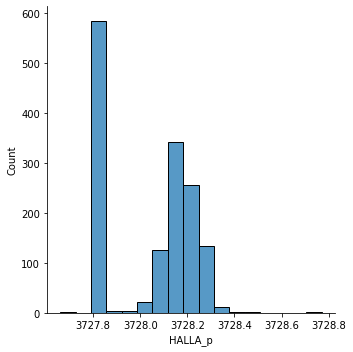

In [18]:
# All runs
sns.displot(data=ebeamdf_nz_nd, x='HALLA_p')

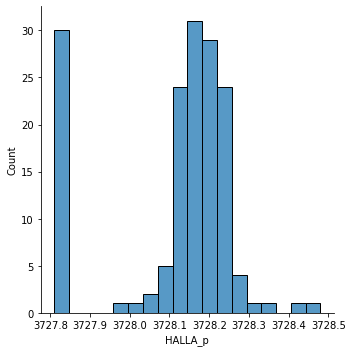

In [19]:
# For a single run of choice
run = ebeamdf_nz_nd['runnum'][0]
sns.displot(data=ebeamdf_nz_nd[ebeamdf_nz_nd['runnum'] == run], x='HALLA_p')

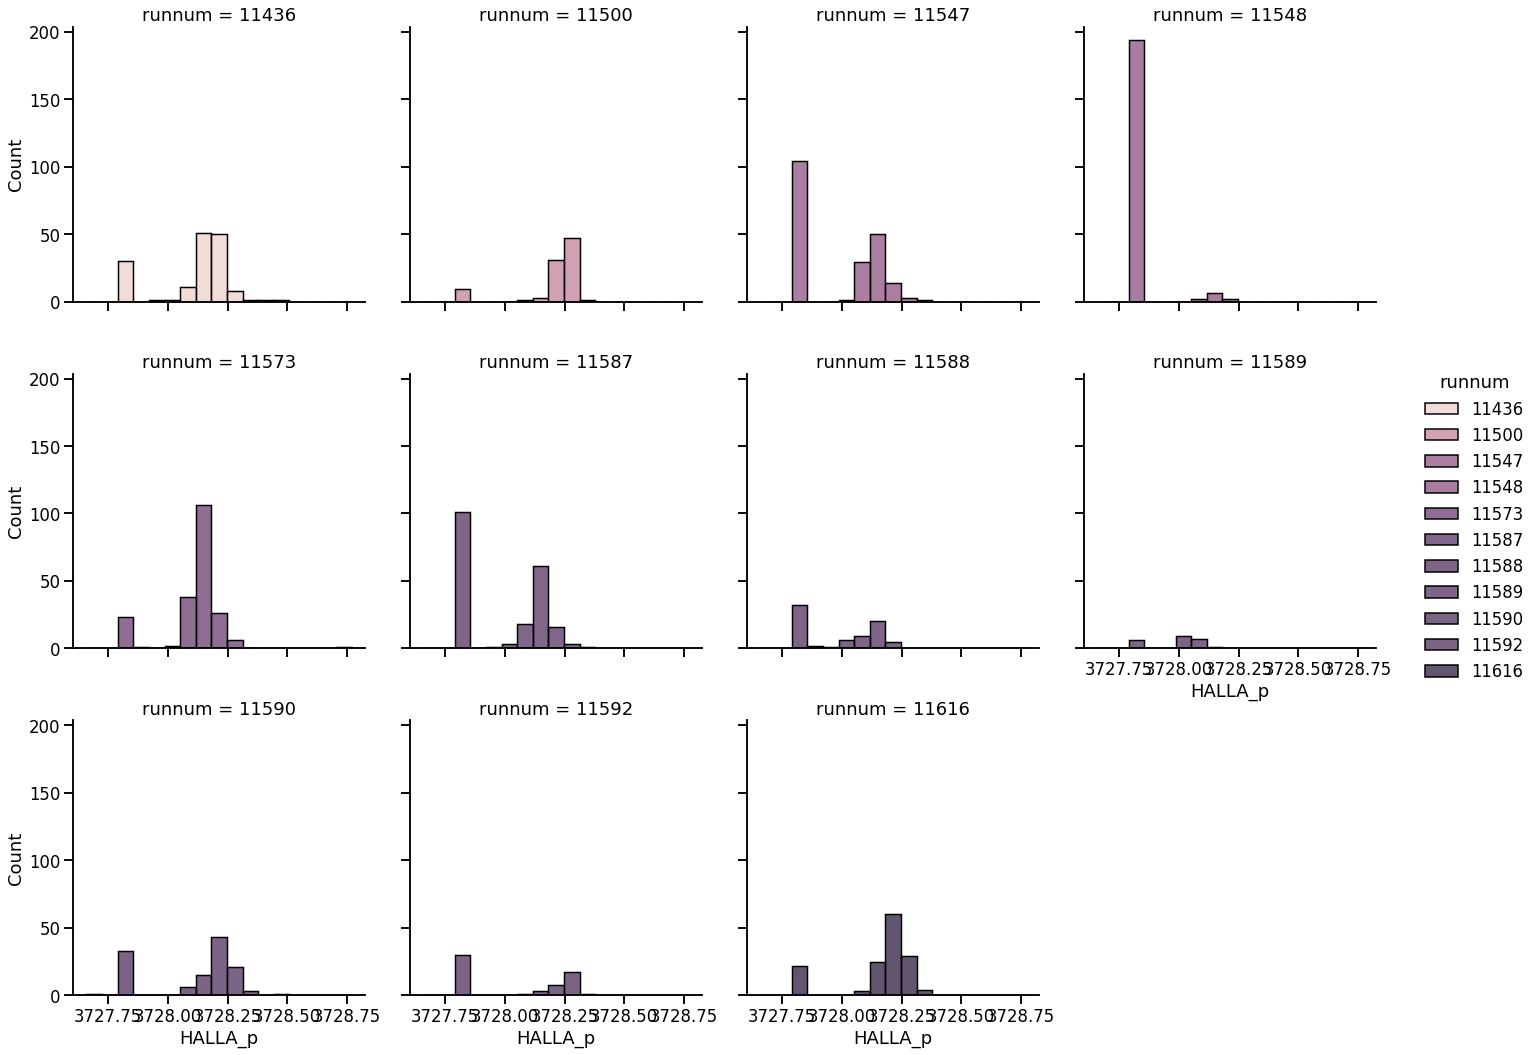

In [20]:
# For all runs at once!
sns.set_context('talk')
sns.displot(data=ebeamdf_nz_nd, x='HALLA_p', hue='runnum', col='runnum', col_wrap=4)